In [60]:
import matplotlib.pyplot as plt
import json
import numpy as np
import glob

# Functions

In [61]:
def read_results(path):
    with open(path, "r") as jsonfile:
        data = json.load(jsonfile)

    accuracy_array = data["task_accuracies"]
    max_len = 0
    for task_accuracy in accuracy_array:
        if len(task_accuracy) > max_len:
            max_len = len(task_accuracy)

    for task_accuracy in accuracy_array:
        for i in range(max_len - len(task_accuracy)):
            task_accuracy.append(0.0)

    accuracy_array = np.array(accuracy_array)
    accuracy_array[accuracy_array == 0.0] = np.nan

    for i, acc_array in enumerate(accuracy_array):
        for j in range(len(acc_array)):
            if i > 0 and np.isnan(acc_array[j]) and not np.isnan(accuracy_array[i - 1][j]):
                accuracy_array[i][j] = 0.0

    return accuracy_array

In [62]:
def average_forgetting(accuracy_arrays):
    T = accuracy_arrays.shape[0]  # Total number of tasks
    forgetting = []

    for t in range(T - 1):
        max_accuracy = np.nanmax(accuracy_arrays[:t + 1, t])
        final_accuracy = accuracy_arrays[T - 1, t]
        f_t = max_accuracy - final_accuracy
        forgetting.append(f_t)

    avg_forgetting = np.mean(forgetting) if forgetting else 0.0
    return forgetting, avg_forgetting

In [63]:
def cumulative_average_multiple_runs(pattern):
    cumulative_averages = []
    cumulative_forgetting = []
    log_files = glob.glob(pattern)
    if len(log_files) == 0:
        print("No files found")
        return 0
    print(f"{len(log_files)} files found")
    for i, log in enumerate(log_files):
        print(f"{i + 1}: {log}")
        task_accuracies = read_results(log)
        cum_avg = [np.nansum(task_accuracies[j]) / (j + 1) for j in range(len(task_accuracies))]
        cumulative_averages.append(cum_avg)
        _, avg_forgetting = average_forgetting(task_accuracies)
        cumulative_forgetting.append(avg_forgetting)
    print(f"FAA: {np.mean(cumulative_averages, axis=0)[-1]:.2f} ± {np.std(cumulative_averages, axis=0)[-1]:.2f}")
    print(f"Avg. Forgetting: {np.mean(cumulative_forgetting, axis=0):.2f} ± {np.std(cumulative_forgetting, axis=0):.2f}")

    return np.round(np.mean(cumulative_averages, axis=0), decimals=2).tolist()

In [64]:
def plot_cumulative_results(title, accuracy_arrays, labels):

    assert len(accuracy_arrays) == len(
        labels
    ), "The number of accuracy arrays and labels must match."

    plt.figure(figsize=(12, 6))

    for idx, (cum_avg_acc, label) in enumerate(zip(accuracy_arrays, labels)):
        plt.plot(range(1, len(cum_avg_acc) + 1), cum_avg_acc, "--o" if idx == 0 else "-o", label=label)
        for j, value in enumerate(cum_avg_acc):
            plt.annotate(
                f"{value:.2f}",
                (j + 1, value),
                textcoords="offset points",
                xytext=(
                    0,
                    -14 if (idx % 2) == 0 else 10,
                ),
                ha="center",
                fontsize=6,
            )

    plt.xlabel("Task Trained On", fontsize=14)
    plt.ylabel("Accuracy (%)", fontsize=14)
    plt.grid(True, linewidth=0.3)
    plt.title(title, fontsize=14)
    plt.xticks(range(1, len(accuracy_arrays[0]) + 1))
    plt.yticks(list(range(0, 106, 5)))
    plt.legend(prop={"size": 12}, loc="lower left")
    plt.show()

In [ ]:
def plot_cumulative_subplots(cumulative_averages, subtitles, labels, plot_filename=""):
    assert len(cumulative_averages) // 4 == len(
        subtitles
    ), "The number of methods and plot subtitles must match."

    colors = [
        "#1f77b4",
        "#d62728",
        "#ff7f0e",
        "#2ca02c",
    ]

    markers = ["--o", "-s", "-^", "-x"]

    fig, axes = plt.subplots(1, len(cumulative_averages) // 4, figsize=(20, 5))

    for i in range(len(cumulative_averages) // 4):
        for j in range(4):
            axes[i].plot(
                range(1, len(cumulative_averages[4 * i + j]) + 1),
                cumulative_averages[4 * i + j],
                markers[j],
                label=f"{labels[j]}",
                color=colors[j],
            )
            axes[i].grid(True, linewidth=0.3)
            axes[i].set_title(subtitles[i], fontsize=24)
            if i == 0: axes[i].legend(prop={"size": 16}, loc="lower left")
            axes[i].set_xticks(range(1, len(cumulative_averages[i]) + 1))
            axes[i].set_yticks(list(range(20, 101, 10)))

    fig.supxlabel("Task Trained On", fontsize=24)
    fig.supylabel("Accuracy (%)\n", fontsize=24)
    plt.tight_layout()
    if plot_filename != "" and len(plot_filename) > 0:
        plt.savefig(plot_filename, format="pdf", dpi=300)
    plt.show()

# ER

## Buffer 500

### Accuracy Without Drift

In [66]:
er_500_accuracy_array_without_drift = cumulative_average_multiple_runs(
    "./reimplementation-logs/*-seq-fashionmnist-er-buf-500-drift-6-s-5-n-1-adaptation-0.json"
)

3 files found
1: ./reimplementation-logs/03-24-25-16-04-18-seq-fashionmnist-er-buf-500-drift-6-s-5-n-1-adaptation-0.json
2: ./reimplementation-logs/03-24-25-16-03-49-seq-fashionmnist-er-buf-500-drift-6-s-5-n-1-adaptation-0.json
3: ./reimplementation-logs/03-24-25-16-03-21-seq-fashionmnist-er-buf-500-drift-6-s-5-n-1-adaptation-0.json
FAA: 74.35 ± 1.27
Avg. Forgetting: 22.86 ± 1.61


### Permutation Drift in Task 3

In [67]:
er_500_accuracy_array_with_drift = cumulative_average_multiple_runs(
    "./reimplementation-logs/*-seq-fashionmnist-er-buf-500-drift-5-s-5-n-1-adaptation-0.json"
)

3 files found
1: ./reimplementation-logs/03-24-25-16-05-44-seq-fashionmnist-er-buf-500-drift-5-s-5-n-1-adaptation-0.json
2: ./reimplementation-logs/03-24-25-16-04-47-seq-fashionmnist-er-buf-500-drift-5-s-5-n-1-adaptation-0.json
3: ./reimplementation-logs/03-24-25-16-05-16-seq-fashionmnist-er-buf-500-drift-5-s-5-n-1-adaptation-0.json
FAA: 63.01 ± 0.66
Avg. Forgetting: 36.69 ± 1.53


### Permutation Drift in Task 3 with Full Relearning

In [68]:
er_500_accuracy_array_with_drift_full_relearning = cumulative_average_multiple_runs(
    "./reimplementation-logs/*-seq-fashionmnist-er-buf-500-drift-5-s-5-n-1-adaptation-1.json"
)

3 files found
1: ./reimplementation-logs/05-01-25-14-04-17-seq-fashionmnist-er-buf-500-drift-5-s-5-n-1-adaptation-1.json
2: ./reimplementation-logs/05-01-25-13-58-08-seq-fashionmnist-er-buf-500-drift-5-s-5-n-1-adaptation-1.json
3: ./reimplementation-logs/05-01-25-14-08-02-seq-fashionmnist-er-buf-500-drift-5-s-5-n-1-adaptation-1.json
FAA: 84.26 ± 0.49
Avg. Forgetting: 18.27 ± 0.59


### Permutation Drift in Task 3 with Buffer Resampling

In [69]:
er_500_accuracy_array_with_drift_buffer_resampling = cumulative_average_multiple_runs(
    "./reimplementation-logs/*-seq-fashionmnist-er-buf-500-drift-5-s-5-n-1-adaptation-2.json"
)

3 files found
1: ./reimplementation-logs/05-01-25-14-14-44-seq-fashionmnist-er-buf-500-drift-5-s-5-n-1-adaptation-2.json
2: ./reimplementation-logs/05-01-25-14-12-22-seq-fashionmnist-er-buf-500-drift-5-s-5-n-1-adaptation-2.json
3: ./reimplementation-logs/05-01-25-14-19-28-seq-fashionmnist-er-buf-500-drift-5-s-5-n-1-adaptation-2.json
FAA: 86.30 ± 0.86
Avg. Forgetting: 15.88 ± 1.18


### Cumulative Plots

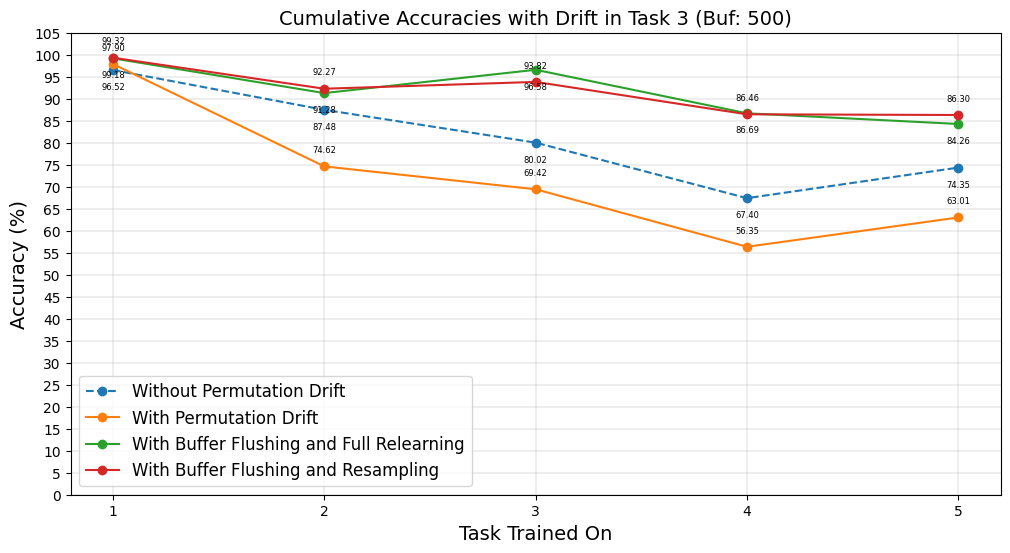

In [70]:
plot_cumulative_results(
    "Cumulative Accuracies with Drift in Task 3 (Buf: 500)",
    [
        er_500_accuracy_array_without_drift,
        er_500_accuracy_array_with_drift,
        er_500_accuracy_array_with_drift_full_relearning,
        er_500_accuracy_array_with_drift_buffer_resampling,
    ],
    [
        "Without Permutation Drift",
        "With Permutation Drift",
        "With Buffer Flushing and Full Relearning",
        "With Buffer Flushing and Resampling",
    ],
)

## Buffer 5000

### Accuracy Without Drift

In [71]:
er_5000_accuracy_array_without_drift = cumulative_average_multiple_runs(
    "./reimplementation-logs/*-seq-fashionmnist-er-buf-5000-drift-6-s-5-n-1-adaptation-0.json"
)

3 files found
1: ./reimplementation-logs/03-24-25-16-07-55-seq-fashionmnist-er-buf-5000-drift-6-s-5-n-1-adaptation-0.json
2: ./reimplementation-logs/03-24-25-16-07-25-seq-fashionmnist-er-buf-5000-drift-6-s-5-n-1-adaptation-0.json
3: ./reimplementation-logs/03-24-25-16-08-27-seq-fashionmnist-er-buf-5000-drift-6-s-5-n-1-adaptation-0.json
FAA: 80.62 ± 0.97
Avg. Forgetting: 17.55 ± 1.11


### Permutation Drift in Task 3

In [72]:
er_5000_accuracy_array_with_drift = cumulative_average_multiple_runs(
    "./reimplementation-logs/*-seq-fashionmnist-er-buf-5000-drift-5-s-5-n-1-adaptation-0.json"
)

3 files found
1: ./reimplementation-logs/03-24-25-16-09-28-seq-fashionmnist-er-buf-5000-drift-5-s-5-n-1-adaptation-0.json
2: ./reimplementation-logs/03-24-25-16-08-57-seq-fashionmnist-er-buf-5000-drift-5-s-5-n-1-adaptation-0.json
3: ./reimplementation-logs/03-24-25-16-09-57-seq-fashionmnist-er-buf-5000-drift-5-s-5-n-1-adaptation-0.json
FAA: 62.51 ± 1.20
Avg. Forgetting: 40.55 ± 1.44


### Permutation Drift in Task 3 with Full Relearning

In [73]:
er_5000_accuracy_array_with_drift_full_relearning = cumulative_average_multiple_runs(
    "./reimplementation-logs/*-seq-fashionmnist-er-buf-5000-drift-5-s-5-n-1-adaptation-1.json"
)

3 files found
1: ./reimplementation-logs/03-24-25-16-11-20-seq-fashionmnist-er-buf-5000-drift-5-s-5-n-1-adaptation-1.json
2: ./reimplementation-logs/03-24-25-16-10-39-seq-fashionmnist-er-buf-5000-drift-5-s-5-n-1-adaptation-1.json
3: ./reimplementation-logs/03-24-25-16-12-01-seq-fashionmnist-er-buf-5000-drift-5-s-5-n-1-adaptation-1.json
FAA: 85.11 ± 1.17
Avg. Forgetting: 10.24 ± 2.00


### Permutation Drift in Task 3 with Buffer Resampling

In [74]:
er_5000_accuracy_array_with_drift_buffer_resampling = cumulative_average_multiple_runs(
    "./reimplementation-logs/*-seq-fashionmnist-er-buf-5000-drift-5-s-5-n-1-adaptation-2.json"
)

3 files found
1: ./reimplementation-logs/03-24-25-16-13-21-seq-fashionmnist-er-buf-5000-drift-5-s-5-n-1-adaptation-2.json
2: ./reimplementation-logs/03-24-25-16-14-17-seq-fashionmnist-er-buf-5000-drift-5-s-5-n-1-adaptation-2.json
3: ./reimplementation-logs/03-24-25-16-12-36-seq-fashionmnist-er-buf-5000-drift-5-s-5-n-1-adaptation-2.json
FAA: 84.51 ± 0.64
Avg. Forgetting: 14.19 ± 1.44


### Cumulative Plots

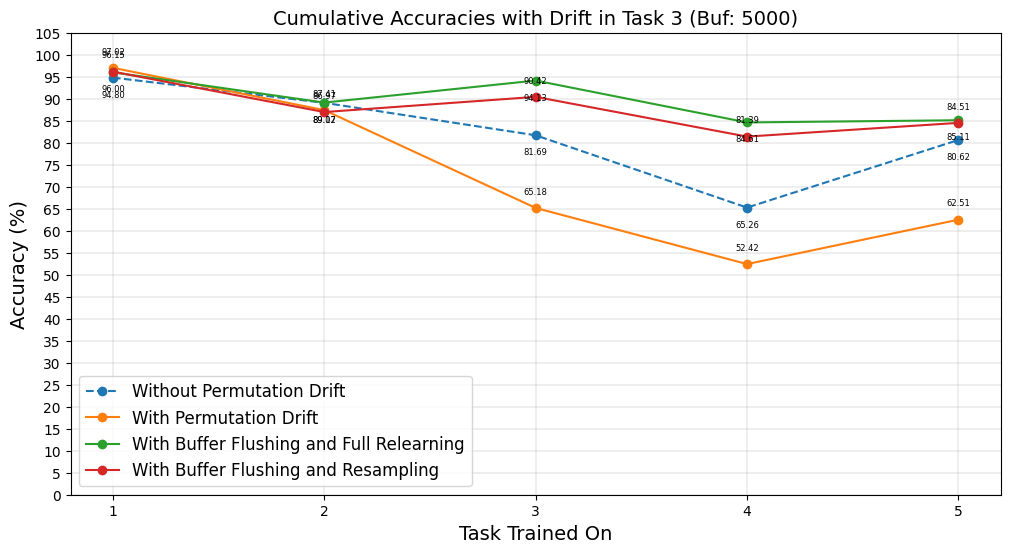

In [75]:
plot_cumulative_results(
    "Cumulative Accuracies with Drift in Task 3 (Buf: 5000)",
    [
        er_5000_accuracy_array_without_drift,
        er_5000_accuracy_array_with_drift,
        er_5000_accuracy_array_with_drift_full_relearning,
        er_5000_accuracy_array_with_drift_buffer_resampling,
    ],
    [
        "Without Permutation Drift",
        "With Permutation Drift",
        "With Buffer Flushing and Full Relearning",
        "With Buffer Flushing and Resampling",
    ],
)

# ER-ACE

## Buffer 500

### Accuracy Without Drift

In [76]:
er_ace_500_accuracy_array_without_drift = cumulative_average_multiple_runs(
    "./reimplementation-logs/*-seq-fashionmnist-er_ace-buf-500-drift-6-s-5-n-1-adaptation-0.json"
)

3 files found
1: ./reimplementation-logs/05-01-25-16-19-12-seq-fashionmnist-er_ace-buf-500-drift-6-s-5-n-1-adaptation-0.json
2: ./reimplementation-logs/05-01-25-16-18-56-seq-fashionmnist-er_ace-buf-500-drift-6-s-5-n-1-adaptation-0.json
3: ./reimplementation-logs/05-01-25-16-19-22-seq-fashionmnist-er_ace-buf-500-drift-6-s-5-n-1-adaptation-0.json
FAA: 82.77 ± 0.14
Avg. Forgetting: 8.32 ± 1.01


### Permutation Drift in Task 3

In [77]:
er_ace_500_accuracy_array_with_drift = cumulative_average_multiple_runs(
    "./reimplementation-logs/*-seq-fashionmnist-er_ace-buf-500-drift-5-s-5-n-1-adaptation-0.json"
)

3 files found
1: ./reimplementation-logs/05-01-25-16-22-49-seq-fashionmnist-er_ace-buf-500-drift-5-s-5-n-1-adaptation-0.json
2: ./reimplementation-logs/05-01-25-16-23-17-seq-fashionmnist-er_ace-buf-500-drift-5-s-5-n-1-adaptation-0.json
3: ./reimplementation-logs/05-01-25-16-23-03-seq-fashionmnist-er_ace-buf-500-drift-5-s-5-n-1-adaptation-0.json
FAA: 73.00 ± 1.67
Avg. Forgetting: 20.71 ± 2.18


### Permutation Drift in Task 3 with Full Relearning

In [78]:
er_ace_500_accuracy_array_with_drift_full_relearning = cumulative_average_multiple_runs(
    "./reimplementation-logs/*-seq-fashionmnist-er_ace-buf-500-drift-5-s-5-n-1-adaptation-1.json"
)

3 files found
1: ./reimplementation-logs/05-01-25-16-27-45-seq-fashionmnist-er_ace-buf-500-drift-5-s-5-n-1-adaptation-1.json
2: ./reimplementation-logs/05-01-25-16-28-08-seq-fashionmnist-er_ace-buf-500-drift-5-s-5-n-1-adaptation-1.json
3: ./reimplementation-logs/05-01-25-16-27-32-seq-fashionmnist-er_ace-buf-500-drift-5-s-5-n-1-adaptation-1.json
FAA: 87.83 ± 0.16
Avg. Forgetting: 1.40 ± 2.38


### Permutation Drift in Task 3 with Buffer Resampling

In [79]:
er_ace_500_accuracy_array_with_drift_buffer_resampling = cumulative_average_multiple_runs(
    "./reimplementation-logs/*-seq-fashionmnist-er_ace-buf-500-drift-5-s-5-n-1-adaptation-2.json"
)

3 files found
1: ./reimplementation-logs/05-01-25-16-33-43-seq-fashionmnist-er_ace-buf-500-drift-5-s-5-n-1-adaptation-2.json
2: ./reimplementation-logs/05-01-25-16-33-57-seq-fashionmnist-er_ace-buf-500-drift-5-s-5-n-1-adaptation-2.json
3: ./reimplementation-logs/05-01-25-16-33-31-seq-fashionmnist-er_ace-buf-500-drift-5-s-5-n-1-adaptation-2.json
FAA: 88.67 ± 0.93
Avg. Forgetting: 6.01 ± 1.23


### Cumulative Plots

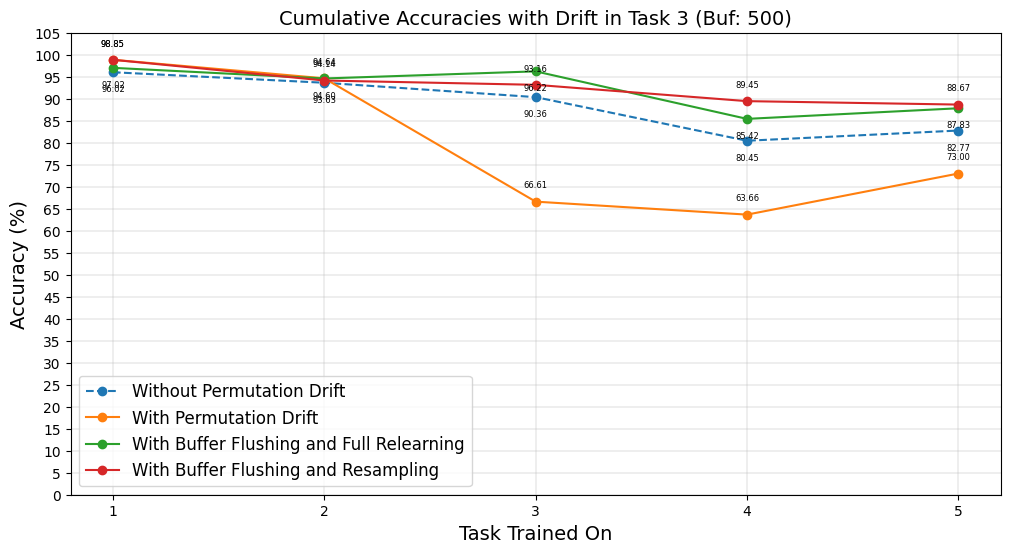

In [80]:
plot_cumulative_results(
    "Cumulative Accuracies with Drift in Task 3 (Buf: 500)",
    [
        er_ace_500_accuracy_array_without_drift,
        er_ace_500_accuracy_array_with_drift,
        er_ace_500_accuracy_array_with_drift_full_relearning,
        er_ace_500_accuracy_array_with_drift_buffer_resampling,
    ],
    [
        "Without Permutation Drift",
        "With Permutation Drift",
        "With Buffer Flushing and Full Relearning",
        "With Buffer Flushing and Resampling",
    ],
)

## Buffer 5000

### Accuracy Without Drift

In [81]:
er_ace_5000_accuracy_array_without_drift = cumulative_average_multiple_runs(
    "./reimplementation-logs/*-seq-fashionmnist-er_ace-buf-5000-drift-6-s-5-n-1-adaptation-0.json"
)

3 files found
1: ./reimplementation-logs/05-01-25-16-39-36-seq-fashionmnist-er_ace-buf-5000-drift-6-s-5-n-1-adaptation-0.json
2: ./reimplementation-logs/05-01-25-16-39-15-seq-fashionmnist-er_ace-buf-5000-drift-6-s-5-n-1-adaptation-0.json
3: ./reimplementation-logs/05-01-25-16-39-08-seq-fashionmnist-er_ace-buf-5000-drift-6-s-5-n-1-adaptation-0.json
FAA: 87.14 ± 0.27
Avg. Forgetting: 3.58 ± 0.49


### Permutation Drift in Task 3

In [82]:
er_ace_5000_accuracy_array_with_drift = cumulative_average_multiple_runs(
    "./reimplementation-logs/*-seq-fashionmnist-er_ace-buf-5000-drift-5-s-5-n-1-adaptation-0.json"
)

3 files found
1: ./reimplementation-logs/05-01-25-16-43-00-seq-fashionmnist-er_ace-buf-5000-drift-5-s-5-n-1-adaptation-0.json
2: ./reimplementation-logs/05-01-25-16-42-55-seq-fashionmnist-er_ace-buf-5000-drift-5-s-5-n-1-adaptation-0.json
3: ./reimplementation-logs/05-01-25-16-42-56-seq-fashionmnist-er_ace-buf-5000-drift-5-s-5-n-1-adaptation-0.json
FAA: 74.89 ± 0.65
Avg. Forgetting: 18.04 ± 0.99


### Permutation Drift in Task 3 with Full Relearning

In [83]:
er_ace_5000_accuracy_array_with_drift_full_relearning = cumulative_average_multiple_runs(
    "./reimplementation-logs/*-seq-fashionmnist-er_ace-buf-5000-drift-5-s-5-n-1-adaptation-1.json"
)

3 files found
1: ./reimplementation-logs/05-01-25-16-48-19-seq-fashionmnist-er_ace-buf-5000-drift-5-s-5-n-1-adaptation-1.json
2: ./reimplementation-logs/05-01-25-16-48-37-seq-fashionmnist-er_ace-buf-5000-drift-5-s-5-n-1-adaptation-1.json
3: ./reimplementation-logs/05-01-25-16-48-34-seq-fashionmnist-er_ace-buf-5000-drift-5-s-5-n-1-adaptation-1.json
FAA: 89.23 ± 0.73
Avg. Forgetting: 0.84 ± 0.81


### Permutation Drift in Task 3 with Buffer Resampling

In [84]:
er_ace_5000_accuracy_array_with_drift_buffer_resampling = cumulative_average_multiple_runs(
    "./reimplementation-logs/*-seq-fashionmnist-er_ace-buf-5000-drift-5-s-5-n-1-adaptation-2.json"
)

3 files found
1: ./reimplementation-logs/05-01-25-16-51-09-seq-fashionmnist-er_ace-buf-5000-drift-5-s-5-n-1-adaptation-2.json
2: ./reimplementation-logs/05-01-25-16-51-15-seq-fashionmnist-er_ace-buf-5000-drift-5-s-5-n-1-adaptation-2.json
3: ./reimplementation-logs/05-01-25-16-51-27-seq-fashionmnist-er_ace-buf-5000-drift-5-s-5-n-1-adaptation-2.json
FAA: 93.39 ± 0.18
Avg. Forgetting: 2.75 ± 0.61


### Cumulative Plots

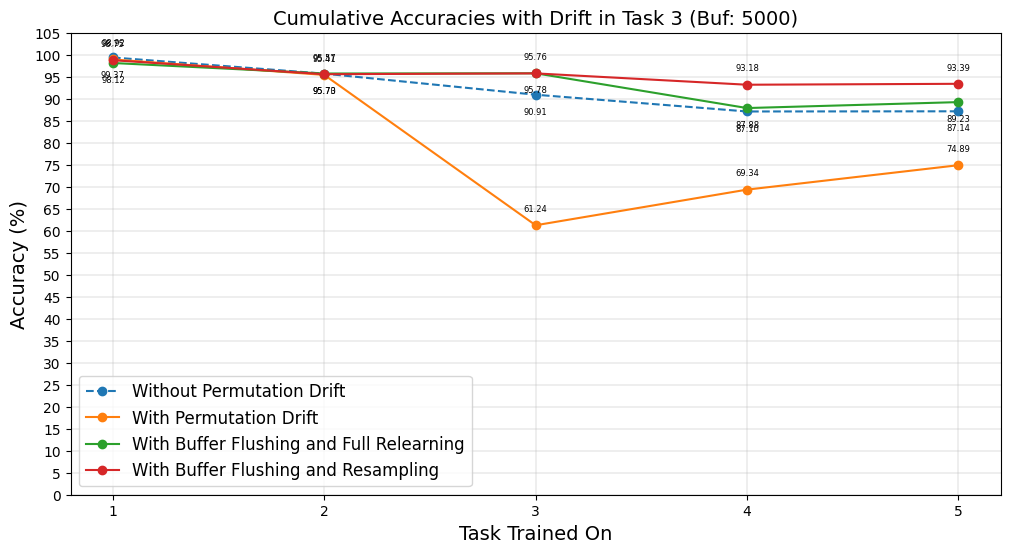

In [85]:
plot_cumulative_results(
    "Cumulative Accuracies with Drift in Task 3 (Buf: 5000)",
    [
        er_ace_5000_accuracy_array_without_drift,
        er_ace_5000_accuracy_array_with_drift,
        er_ace_5000_accuracy_array_with_drift_full_relearning,
        er_ace_5000_accuracy_array_with_drift_buffer_resampling,
    ],
    [
        "Without Permutation Drift",
        "With Permutation Drift",
        "With Buffer Flushing and Full Relearning",
        "With Buffer Flushing and Resampling",
    ],
)

# DER++

## Buffer 500

### Accuracy Without Drift

In [86]:
derpp_500_accuracy_array_without_drift = cumulative_average_multiple_runs(
    "./reimplementation-logs/*-seq-fashionmnist-derpp-buf-500-drift-6-s-5-n-1-adaptation-0.json"
)

3 files found
1: ./reimplementation-logs/05-01-25-17-00-50-seq-fashionmnist-derpp-buf-500-drift-6-s-5-n-1-adaptation-0.json
2: ./reimplementation-logs/05-01-25-17-01-14-seq-fashionmnist-derpp-buf-500-drift-6-s-5-n-1-adaptation-0.json
3: ./reimplementation-logs/05-01-25-17-01-34-seq-fashionmnist-derpp-buf-500-drift-6-s-5-n-1-adaptation-0.json
FAA: 81.92 ± 0.07
Avg. Forgetting: 14.07 ± 1.47


### Permutation Drift in Task 3

In [87]:
derpp_500_accuracy_array_with_drift = cumulative_average_multiple_runs(
    "./reimplementation-logs/*-seq-fashionmnist-derpp-buf-500-drift-5-s-5-n-1-adaptation-0.json"
)

3 files found
1: ./reimplementation-logs/05-01-25-17-05-47-seq-fashionmnist-derpp-buf-500-drift-5-s-5-n-1-adaptation-0.json
2: ./reimplementation-logs/05-01-25-17-06-08-seq-fashionmnist-derpp-buf-500-drift-5-s-5-n-1-adaptation-0.json
3: ./reimplementation-logs/05-01-25-17-09-28-seq-fashionmnist-derpp-buf-500-drift-5-s-5-n-1-adaptation-0.json
FAA: 69.69 ± 0.87
Avg. Forgetting: 27.07 ± 1.11


### Permutation Drift in Task 3 with Full Relearning

In [88]:
derpp_500_accuracy_array_with_drift_full_relearning = cumulative_average_multiple_runs(
    "./reimplementation-logs/*-seq-fashionmnist-derpp-buf-500-drift-5-s-5-n-1-adaptation-1.json"
)

3 files found
1: ./reimplementation-logs/05-01-25-17-21-33-seq-fashionmnist-derpp-buf-500-drift-5-s-5-n-1-adaptation-1.json
2: ./reimplementation-logs/05-01-25-17-21-51-seq-fashionmnist-derpp-buf-500-drift-5-s-5-n-1-adaptation-1.json
3: ./reimplementation-logs/05-01-25-17-21-40-seq-fashionmnist-derpp-buf-500-drift-5-s-5-n-1-adaptation-1.json
FAA: 89.13 ± 0.42
Avg. Forgetting: 7.93 ± 0.94


### Permutation Drift in Task 3 with Buffer Resampling

In [89]:
derpp_500_accuracy_array_with_drift_buffer_resampling = cumulative_average_multiple_runs(
    "./reimplementation-logs/*-seq-fashionmnist-derpp-buf-500-drift-5-s-5-n-1-adaptation-2.json"
)

3 files found
1: ./reimplementation-logs/05-02-25-12-25-15-seq-fashionmnist-derpp-buf-500-drift-5-s-5-n-1-adaptation-2.json
2: ./reimplementation-logs/05-02-25-12-24-31-seq-fashionmnist-derpp-buf-500-drift-5-s-5-n-1-adaptation-2.json
3: ./reimplementation-logs/05-02-25-12-24-50-seq-fashionmnist-derpp-buf-500-drift-5-s-5-n-1-adaptation-2.json
FAA: 88.28 ± 0.90
Avg. Forgetting: 10.27 ± 1.22


### Cumulative Plots

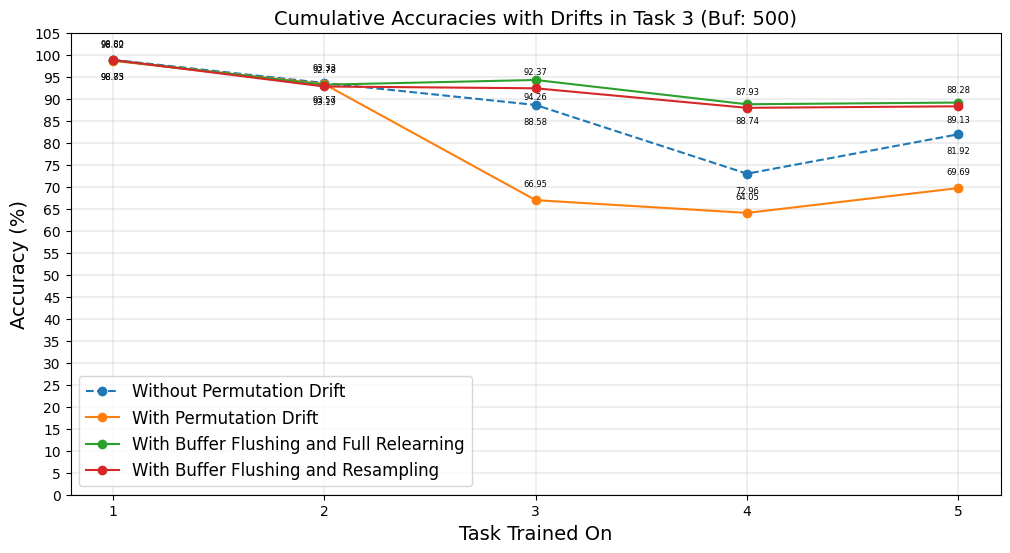

In [90]:
plot_cumulative_results(
    "Cumulative Accuracies with Drifts in Task 3 (Buf: 500)",
    [
        derpp_500_accuracy_array_without_drift,
        derpp_500_accuracy_array_with_drift,
        derpp_500_accuracy_array_with_drift_full_relearning,
        derpp_500_accuracy_array_with_drift_buffer_resampling,
    ],
    [
        "Without Permutation Drift",
        "With Permutation Drift",
        "With Buffer Flushing and Full Relearning",
        "With Buffer Flushing and Resampling",
    ],
)

## Buffer 5000

### Accuracy Without Drift

In [91]:
derpp_5000_accuracy_array_without_drift = cumulative_average_multiple_runs(
    "./reimplementation-logs/*-seq-fashionmnist-derpp-buf-5000-drift-6-s-5-n-1-adaptation-0.json"
)

3 files found
1: ./reimplementation-logs/05-02-25-12-39-47-seq-fashionmnist-derpp-buf-5000-drift-6-s-5-n-1-adaptation-0.json
2: ./reimplementation-logs/05-02-25-12-40-43-seq-fashionmnist-derpp-buf-5000-drift-6-s-5-n-1-adaptation-0.json
3: ./reimplementation-logs/05-02-25-12-40-19-seq-fashionmnist-derpp-buf-5000-drift-6-s-5-n-1-adaptation-0.json
FAA: 87.99 ± 0.13
Avg. Forgetting: 5.88 ± 0.13


### Permutation Drift in Task 3

In [92]:
derpp_5000_accuracy_array_with_drift = cumulative_average_multiple_runs(
    "./reimplementation-logs/*-seq-fashionmnist-derpp-buf-5000-drift-5-s-5-n-1-adaptation-0.json"
)

3 files found
1: ./reimplementation-logs/05-02-25-12-50-10-seq-fashionmnist-derpp-buf-5000-drift-5-s-5-n-1-adaptation-0.json
2: ./reimplementation-logs/05-02-25-12-54-07-seq-fashionmnist-derpp-buf-5000-drift-5-s-5-n-1-adaptation-0.json
3: ./reimplementation-logs/05-02-25-12-50-41-seq-fashionmnist-derpp-buf-5000-drift-5-s-5-n-1-adaptation-0.json
FAA: 74.27 ± 1.16
Avg. Forgetting: 23.23 ± 1.32


### Permutation Drift in Task 3 with Full Relearning

In [93]:
derpp_5000_accuracy_array_with_drift_full_relearning = cumulative_average_multiple_runs(
    "./reimplementation-logs/*-seq-fashionmnist-derpp-buf-5000-drift-5-s-5-n-1-adaptation-1.json"
)

3 files found
1: ./reimplementation-logs/05-02-25-13-00-14-seq-fashionmnist-derpp-buf-5000-drift-5-s-5-n-1-adaptation-1.json
2: ./reimplementation-logs/05-02-25-13-00-35-seq-fashionmnist-derpp-buf-5000-drift-5-s-5-n-1-adaptation-1.json
3: ./reimplementation-logs/05-02-25-13-00-26-seq-fashionmnist-derpp-buf-5000-drift-5-s-5-n-1-adaptation-1.json
FAA: 90.70 ± 0.61
Avg. Forgetting: 4.83 ± 1.81


### Permutation Drift in Task 3 with Buffer Resampling

In [94]:
derpp_5000_accuracy_array_with_drift_buffer_resampling = cumulative_average_multiple_runs(
    "./reimplementation-logs/*-seq-fashionmnist-derpp-buf-5000-drift-5-s-5-n-1-adaptation-2.json"
)

3 files found
1: ./reimplementation-logs/05-02-25-13-04-42-seq-fashionmnist-derpp-buf-5000-drift-5-s-5-n-1-adaptation-2.json
2: ./reimplementation-logs/05-02-25-13-05-24-seq-fashionmnist-derpp-buf-5000-drift-5-s-5-n-1-adaptation-2.json
3: ./reimplementation-logs/05-02-25-13-04-14-seq-fashionmnist-derpp-buf-5000-drift-5-s-5-n-1-adaptation-2.json
FAA: 91.82 ± 0.28
Avg. Forgetting: 5.73 ± 0.51


### Cumulative Plots

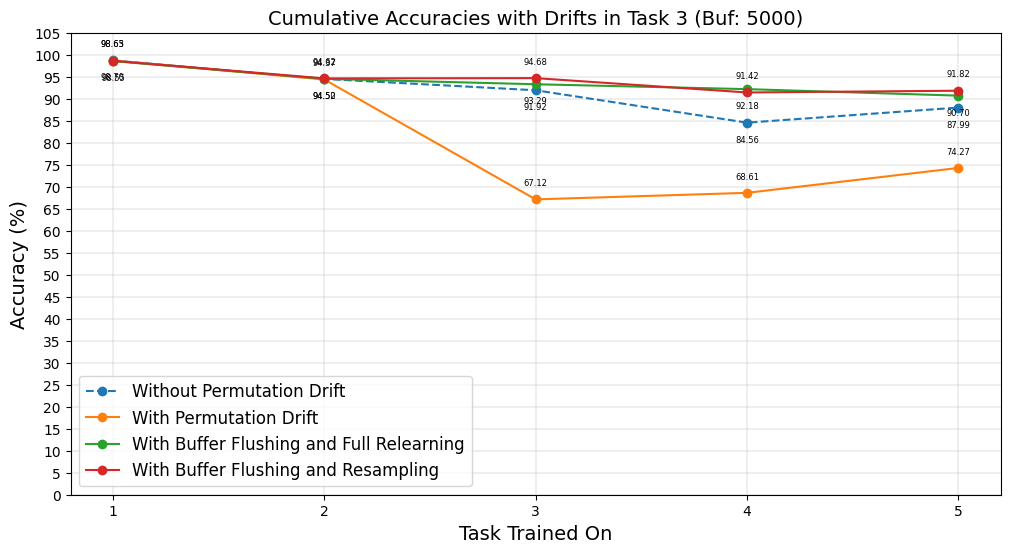

In [95]:
plot_cumulative_results(
    "Cumulative Accuracies with Drifts in Task 3 (Buf: 5000)",
    [
        derpp_5000_accuracy_array_without_drift,
        derpp_5000_accuracy_array_with_drift,
        derpp_5000_accuracy_array_with_drift_full_relearning,
        derpp_5000_accuracy_array_with_drift_buffer_resampling,
    ],
    [
        "Without Permutation Drift",
        "With Permutation Drift",
        "With Buffer Flushing and Full Relearning",
        "With Buffer Flushing and Resampling",
    ],
)

# SER

## Buffer 500

### Accuracy Without Drift

In [96]:
ser_500_accuracy_array_without_drift = cumulative_average_multiple_runs(
    "./reimplementation-logs/*-seq-fashionmnist-ser-buf-500-drift-6-s-5-n-1-adaptation-0.json"
)

3 files found
1: ./reimplementation-logs/05-04-25-18-16-02-seq-fashionmnist-ser-buf-500-drift-6-s-5-n-1-adaptation-0.json
2: ./reimplementation-logs/05-04-25-18-17-07-seq-fashionmnist-ser-buf-500-drift-6-s-5-n-1-adaptation-0.json
3: ./reimplementation-logs/05-04-25-18-16-29-seq-fashionmnist-ser-buf-500-drift-6-s-5-n-1-adaptation-0.json
FAA: 81.38 ± 0.47
Avg. Forgetting: 13.19 ± 1.66


### Permutation Drift in Task 3

In [97]:
ser_500_accuracy_array_with_drift = cumulative_average_multiple_runs(
    "./reimplementation-logs/*-seq-fashionmnist-ser-buf-500-drift-5-s-5-n-1-adaptation-0.json"
)

3 files found
1: ./reimplementation-logs/05-04-25-18-29-34-seq-fashionmnist-ser-buf-500-drift-5-s-5-n-1-adaptation-0.json
2: ./reimplementation-logs/05-04-25-18-26-12-seq-fashionmnist-ser-buf-500-drift-5-s-5-n-1-adaptation-0.json
3: ./reimplementation-logs/05-04-25-18-26-29-seq-fashionmnist-ser-buf-500-drift-5-s-5-n-1-adaptation-0.json
FAA: 70.32 ± 0.99
Avg. Forgetting: 26.39 ± 0.91


### Permutation Drift in Task 3 with Full Relearning

In [98]:
ser_500_accuracy_array_with_drift_full_relearning = cumulative_average_multiple_runs(
    "./reimplementation-logs/*-seq-fashionmnist-ser-buf-500-drift-5-s-5-n-1-adaptation-1.json"
)

3 files found
1: ./reimplementation-logs/05-04-25-18-33-54-seq-fashionmnist-ser-buf-500-drift-5-s-5-n-1-adaptation-1.json
2: ./reimplementation-logs/05-04-25-18-38-21-seq-fashionmnist-ser-buf-500-drift-5-s-5-n-1-adaptation-1.json
3: ./reimplementation-logs/05-04-25-18-33-53-seq-fashionmnist-ser-buf-500-drift-5-s-5-n-1-adaptation-1.json
FAA: 86.86 ± 0.15
Avg. Forgetting: 7.38 ± 0.46


### Permutation Drift in Task 3 with Buffer Resampling

In [99]:
ser_500_accuracy_array_with_drift_buffer_resampling = cumulative_average_multiple_runs(
    "./reimplementation-logs/*-seq-fashionmnist-ser-buf-500-drift-5-s-5-n-1-adaptation-2.json"
)

3 files found
1: ./reimplementation-logs/05-04-25-18-42-02-seq-fashionmnist-ser-buf-500-drift-5-s-5-n-1-adaptation-2.json
2: ./reimplementation-logs/05-04-25-18-41-26-seq-fashionmnist-ser-buf-500-drift-5-s-5-n-1-adaptation-2.json
3: ./reimplementation-logs/05-04-25-18-41-38-seq-fashionmnist-ser-buf-500-drift-5-s-5-n-1-adaptation-2.json
FAA: 89.39 ± 0.15
Avg. Forgetting: 6.04 ± 0.43


### Cumulative Plots

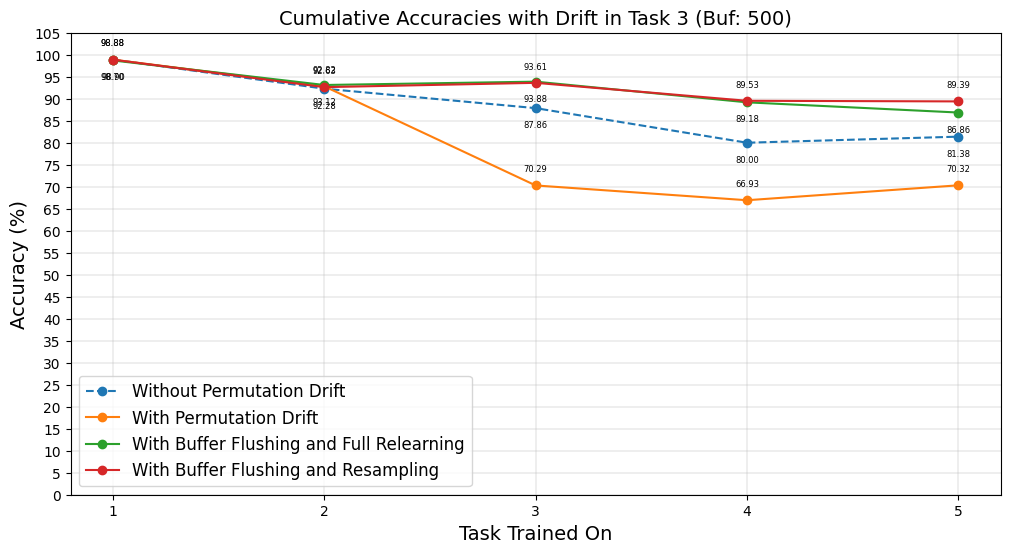

In [100]:
plot_cumulative_results(
    "Cumulative Accuracies with Drift in Task 3 (Buf: 500)",
    [
        ser_500_accuracy_array_without_drift,
        ser_500_accuracy_array_with_drift,
        ser_500_accuracy_array_with_drift_full_relearning,
        ser_500_accuracy_array_with_drift_buffer_resampling,
    ],
    [
        "Without Permutation Drift",
        "With Permutation Drift",
        "With Buffer Flushing and Full Relearning",
        "With Buffer Flushing and Resampling",
    ],
)

## Buffer 5000

### Accuracy Without Drift

In [101]:
ser_5000_accuracy_array_without_drift = cumulative_average_multiple_runs(
    "./reimplementation-logs/*-seq-fashionmnist-ser-buf-5000-drift-6-s-5-n-1-adaptation-0.json"
)

3 files found
1: ./reimplementation-logs/05-04-25-18-45-47-seq-fashionmnist-ser-buf-5000-drift-6-s-5-n-1-adaptation-0.json
2: ./reimplementation-logs/05-04-25-18-45-13-seq-fashionmnist-ser-buf-5000-drift-6-s-5-n-1-adaptation-0.json
3: ./reimplementation-logs/05-04-25-18-45-31-seq-fashionmnist-ser-buf-5000-drift-6-s-5-n-1-adaptation-0.json
FAA: 87.50 ± 0.22
Avg. Forgetting: 3.78 ± 0.62


### Permutation Drift in Task 3

In [102]:
ser_5000_accuracy_array_with_drift = cumulative_average_multiple_runs(
    "./reimplementation-logs/*-seq-fashionmnist-ser-buf-5000-drift-5-s-5-n-1-adaptation-0.json"
)

3 files found
1: ./reimplementation-logs/05-04-25-18-49-08-seq-fashionmnist-ser-buf-5000-drift-5-s-5-n-1-adaptation-0.json
2: ./reimplementation-logs/05-04-25-18-49-18-seq-fashionmnist-ser-buf-5000-drift-5-s-5-n-1-adaptation-0.json
3: ./reimplementation-logs/05-04-25-18-49-32-seq-fashionmnist-ser-buf-5000-drift-5-s-5-n-1-adaptation-0.json
FAA: 72.86 ± 0.57
Avg. Forgetting: 22.27 ± 0.43


### Permutation Drift in Task 3 with Full Relearning

In [103]:
ser_5000_accuracy_array_with_drift_full_relearning = cumulative_average_multiple_runs(
    "./reimplementation-logs/*-seq-fashionmnist-ser-buf-5000-drift-5-s-5-n-1-adaptation-1.json"
)

3 files found
1: ./reimplementation-logs/05-04-25-18-55-27-seq-fashionmnist-ser-buf-5000-drift-5-s-5-n-1-adaptation-1.json
2: ./reimplementation-logs/05-04-25-18-55-18-seq-fashionmnist-ser-buf-5000-drift-5-s-5-n-1-adaptation-1.json
3: ./reimplementation-logs/05-04-25-18-56-02-seq-fashionmnist-ser-buf-5000-drift-5-s-5-n-1-adaptation-1.json
FAA: 89.08 ± 0.43
Avg. Forgetting: 1.14 ± 0.20


### Permutation Drift in Task 3 with Buffer Resampling

In [104]:
ser_5000_accuracy_array_with_drift_buffer_resampling = cumulative_average_multiple_runs(
    "./reimplementation-logs/*-seq-fashionmnist-ser-buf-5000-drift-5-s-5-n-1-adaptation-2.json"
)

3 files found
1: ./reimplementation-logs/05-04-25-19-01-14-seq-fashionmnist-ser-buf-5000-drift-5-s-5-n-1-adaptation-2.json
2: ./reimplementation-logs/05-04-25-19-01-13-seq-fashionmnist-ser-buf-5000-drift-5-s-5-n-1-adaptation-2.json
3: ./reimplementation-logs/05-04-25-19-01-24-seq-fashionmnist-ser-buf-5000-drift-5-s-5-n-1-adaptation-2.json
FAA: 91.39 ± 0.79
Avg. Forgetting: 6.13 ± 1.33


### Cumulative Plots

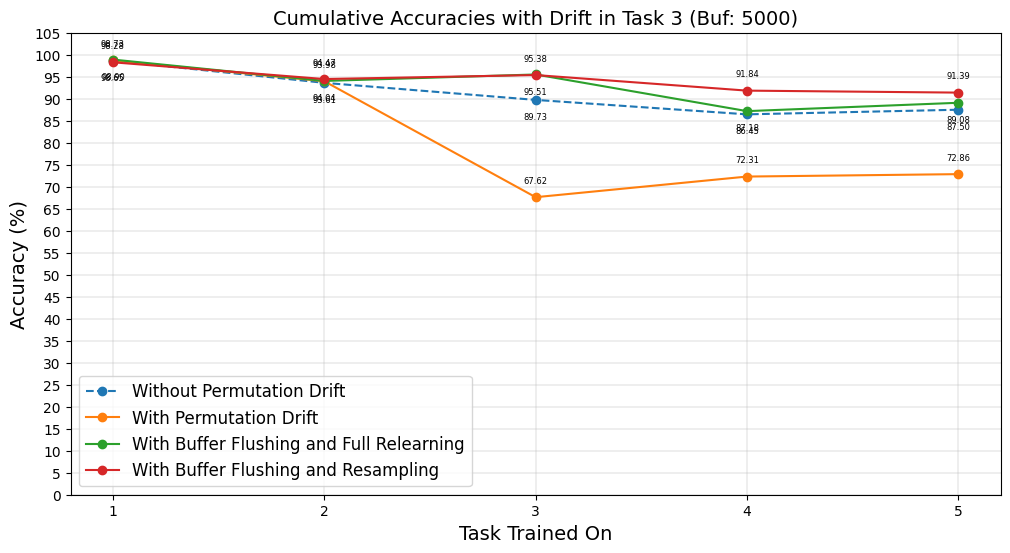

In [105]:
plot_cumulative_results(
    "Cumulative Accuracies with Drift in Task 3 (Buf: 5000)",
    [
        ser_5000_accuracy_array_without_drift,
        ser_5000_accuracy_array_with_drift,
        ser_5000_accuracy_array_with_drift_full_relearning,
        ser_5000_accuracy_array_with_drift_buffer_resampling,
    ],
    [
        "Without Permutation Drift",
        "With Permutation Drift",
        "With Buffer Flushing and Full Relearning",
        "With Buffer Flushing and Resampling",
    ],
)

# CLSER

## Buffer 500

### Accuracy Without Drift

In [106]:
clser_500_accuracy_array_without_drift = cumulative_average_multiple_runs(
    "./reimplementation-logs/*-seq-fashionmnist-clser-buf-500-drift-6-s-5-n-1-adaptation-0.json"
)

3 files found
1: ./reimplementation-logs/05-04-25-19-23-40-seq-fashionmnist-clser-buf-500-drift-6-s-5-n-1-adaptation-0.json
2: ./reimplementation-logs/05-04-25-19-13-17-seq-fashionmnist-clser-buf-500-drift-6-s-5-n-1-adaptation-0.json
3: ./reimplementation-logs/05-04-25-19-13-53-seq-fashionmnist-clser-buf-500-drift-6-s-5-n-1-adaptation-0.json
FAA: 79.98 ± 0.72
Avg. Forgetting: 18.82 ± 1.67


### Permutation Drift in Task 3

In [107]:
clser_500_accuracy_array_with_drift = cumulative_average_multiple_runs(
    "./reimplementation-logs/*-seq-fashionmnist-clser-buf-500-drift-5-s-5-n-1-adaptation-0.json"
)

3 files found
1: ./reimplementation-logs/05-04-25-19-48-53-seq-fashionmnist-clser-buf-500-drift-5-s-5-n-1-adaptation-0.json
2: ./reimplementation-logs/05-04-25-19-48-38-seq-fashionmnist-clser-buf-500-drift-5-s-5-n-1-adaptation-0.json
3: ./reimplementation-logs/05-04-25-19-49-13-seq-fashionmnist-clser-buf-500-drift-5-s-5-n-1-adaptation-0.json
FAA: 68.13 ± 1.64
Avg. Forgetting: 33.45 ± 2.00


### Permutation Drift in Task 3 with Full Relearning

In [108]:
clser_500_accuracy_array_with_drift_full_relearning = cumulative_average_multiple_runs(
    "./reimplementation-logs/*-seq-fashionmnist-clser-buf-500-drift-5-s-5-n-1-adaptation-1.json"
)

3 files found
1: ./reimplementation-logs/05-04-25-19-54-15-seq-fashionmnist-clser-buf-500-drift-5-s-5-n-1-adaptation-1.json
2: ./reimplementation-logs/05-04-25-19-53-51-seq-fashionmnist-clser-buf-500-drift-5-s-5-n-1-adaptation-1.json
3: ./reimplementation-logs/05-04-25-19-54-09-seq-fashionmnist-clser-buf-500-drift-5-s-5-n-1-adaptation-1.json
FAA: 76.52 ± 0.29
Avg. Forgetting: 24.44 ± 1.19


### Permutation Drift in Task 3 with Buffer Resampling

In [109]:
clser_500_accuracy_array_with_drift_buffer_resampling = cumulative_average_multiple_runs(
    "./reimplementation-logs/*-seq-fashionmnist-clser-buf-500-drift-5-s-5-n-1-adaptation-2.json"
)

3 files found
1: ./reimplementation-logs/05-04-25-19-57-36-seq-fashionmnist-clser-buf-500-drift-5-s-5-n-1-adaptation-2.json
2: ./reimplementation-logs/05-04-25-19-57-58-seq-fashionmnist-clser-buf-500-drift-5-s-5-n-1-adaptation-2.json
3: ./reimplementation-logs/05-04-25-19-57-26-seq-fashionmnist-clser-buf-500-drift-5-s-5-n-1-adaptation-2.json
FAA: 76.37 ± 0.61
Avg. Forgetting: 25.30 ± 0.81


### Cumulative Plots

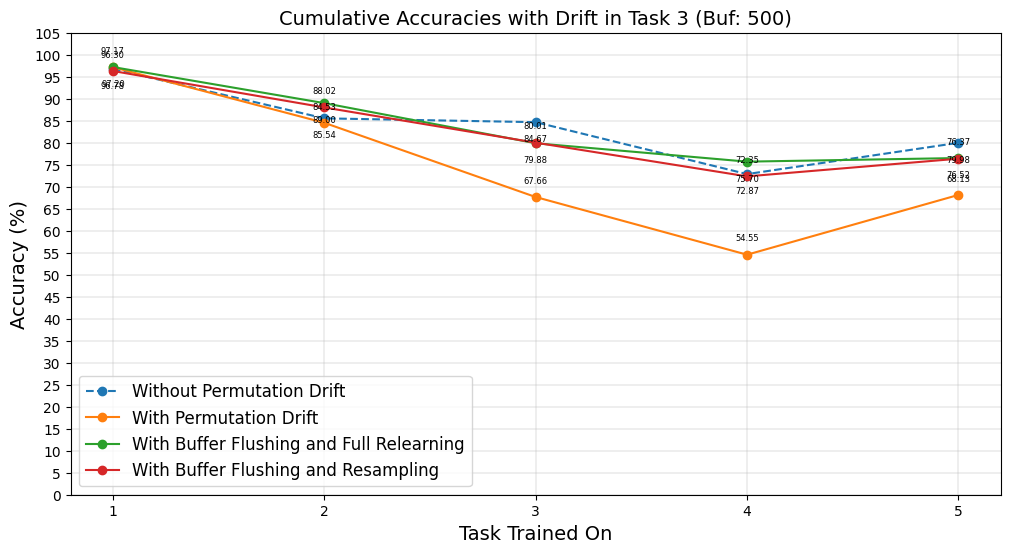

In [110]:
plot_cumulative_results(
    "Cumulative Accuracies with Drift in Task 3 (Buf: 500)",
    [
        clser_500_accuracy_array_without_drift,
        clser_500_accuracy_array_with_drift,
        clser_500_accuracy_array_with_drift_full_relearning,
        clser_500_accuracy_array_with_drift_buffer_resampling,
    ],
    [
        "Without Permutation Drift",
        "With Permutation Drift",
        "With Buffer Flushing and Full Relearning",
        "With Buffer Flushing and Resampling",
    ],
)

## Buffer 5000

### Accuracy Without Drift

In [111]:
clser_5000_accuracy_array_without_drift = cumulative_average_multiple_runs(
    "./reimplementation-logs/*-seq-fashionmnist-clser-buf-5000-drift-6-s-5-n-1-adaptation-0.json"
)

3 files found
1: ./reimplementation-logs/05-04-25-20-05-06-seq-fashionmnist-clser-buf-5000-drift-6-s-5-n-1-adaptation-0.json
2: ./reimplementation-logs/05-04-25-20-04-45-seq-fashionmnist-clser-buf-5000-drift-6-s-5-n-1-adaptation-0.json
3: ./reimplementation-logs/05-04-25-20-04-26-seq-fashionmnist-clser-buf-5000-drift-6-s-5-n-1-adaptation-0.json
FAA: 78.17 ± 1.63
Avg. Forgetting: 22.24 ± 1.45


### Permutation Drift in Task 3

In [112]:
clser_5000_accuracy_array_with_drift = cumulative_average_multiple_runs(
    "./reimplementation-logs/*-seq-fashionmnist-clser-buf-5000-drift-5-s-5-n-1-adaptation-0.json"
)

3 files found
1: ./reimplementation-logs/05-04-25-20-09-48-seq-fashionmnist-clser-buf-5000-drift-5-s-5-n-1-adaptation-0.json
2: ./reimplementation-logs/05-04-25-20-09-06-seq-fashionmnist-clser-buf-5000-drift-5-s-5-n-1-adaptation-0.json
3: ./reimplementation-logs/05-04-25-20-09-24-seq-fashionmnist-clser-buf-5000-drift-5-s-5-n-1-adaptation-0.json
FAA: 59.91 ± 1.13
Avg. Forgetting: 43.87 ± 1.77


### Permutation Drift in Task 3 with Full Relearning

In [113]:
clser_5000_accuracy_array_with_drift_full_relearning = cumulative_average_multiple_runs(
    "./reimplementation-logs/*-seq-fashionmnist-clser-buf-5000-drift-5-s-5-n-1-adaptation-1.json"
)

3 files found
1: ./reimplementation-logs/05-04-25-20-18-55-seq-fashionmnist-clser-buf-5000-drift-5-s-5-n-1-adaptation-1.json
2: ./reimplementation-logs/05-04-25-20-18-38-seq-fashionmnist-clser-buf-5000-drift-5-s-5-n-1-adaptation-1.json
3: ./reimplementation-logs/05-04-25-20-18-20-seq-fashionmnist-clser-buf-5000-drift-5-s-5-n-1-adaptation-1.json
FAA: 87.37 ± 0.13
Avg. Forgetting: 10.93 ± 0.13


### Permutation Drift in Task 3 with Buffer Resampling

In [114]:
clser_5000_accuracy_array_with_drift_buffer_resampling = cumulative_average_multiple_runs(
    "./reimplementation-logs/*-seq-fashionmnist-clser-buf-5000-drift-5-s-5-n-1-adaptation-2.json"
)

3 files found
1: ./reimplementation-logs/05-04-25-20-23-04-seq-fashionmnist-clser-buf-5000-drift-5-s-5-n-1-adaptation-2.json
2: ./reimplementation-logs/05-04-25-20-22-51-seq-fashionmnist-clser-buf-5000-drift-5-s-5-n-1-adaptation-2.json
3: ./reimplementation-logs/05-04-25-20-22-39-seq-fashionmnist-clser-buf-5000-drift-5-s-5-n-1-adaptation-2.json
FAA: 87.44 ± 0.45
Avg. Forgetting: 11.92 ± 0.66


### Cumulative Plots

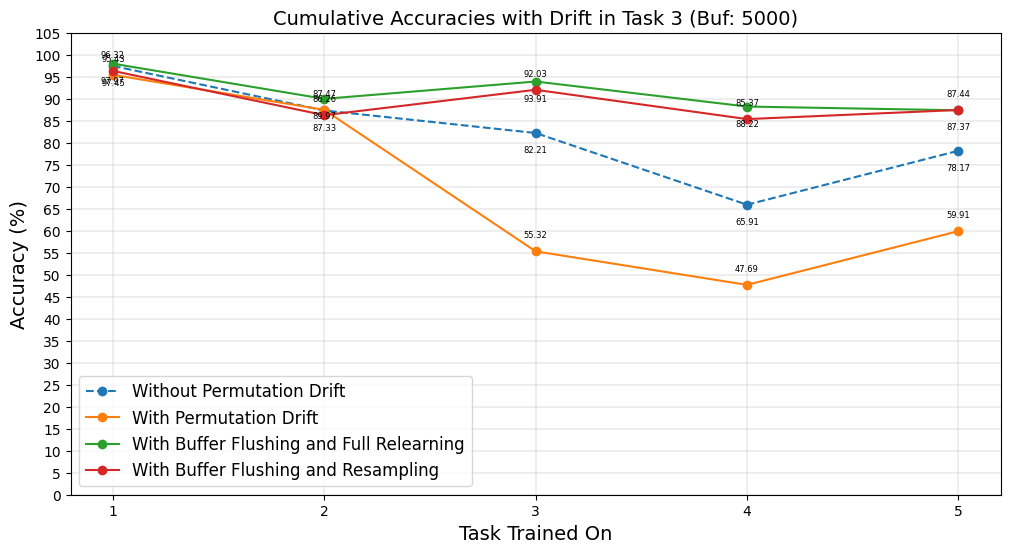

In [115]:
plot_cumulative_results(
    "Cumulative Accuracies with Drift in Task 3 (Buf: 5000)",
    [
        clser_5000_accuracy_array_without_drift,
        clser_5000_accuracy_array_with_drift,
        clser_5000_accuracy_array_with_drift_full_relearning,
        clser_5000_accuracy_array_with_drift_buffer_resampling,
    ],
    [
        "Without Permutation Drift",
        "With Permutation Drift",
        "With Buffer Flushing and Full Relearning",
        "With Buffer Flushing and Resampling",
    ],
)

# Comparisons

## Buffer 500

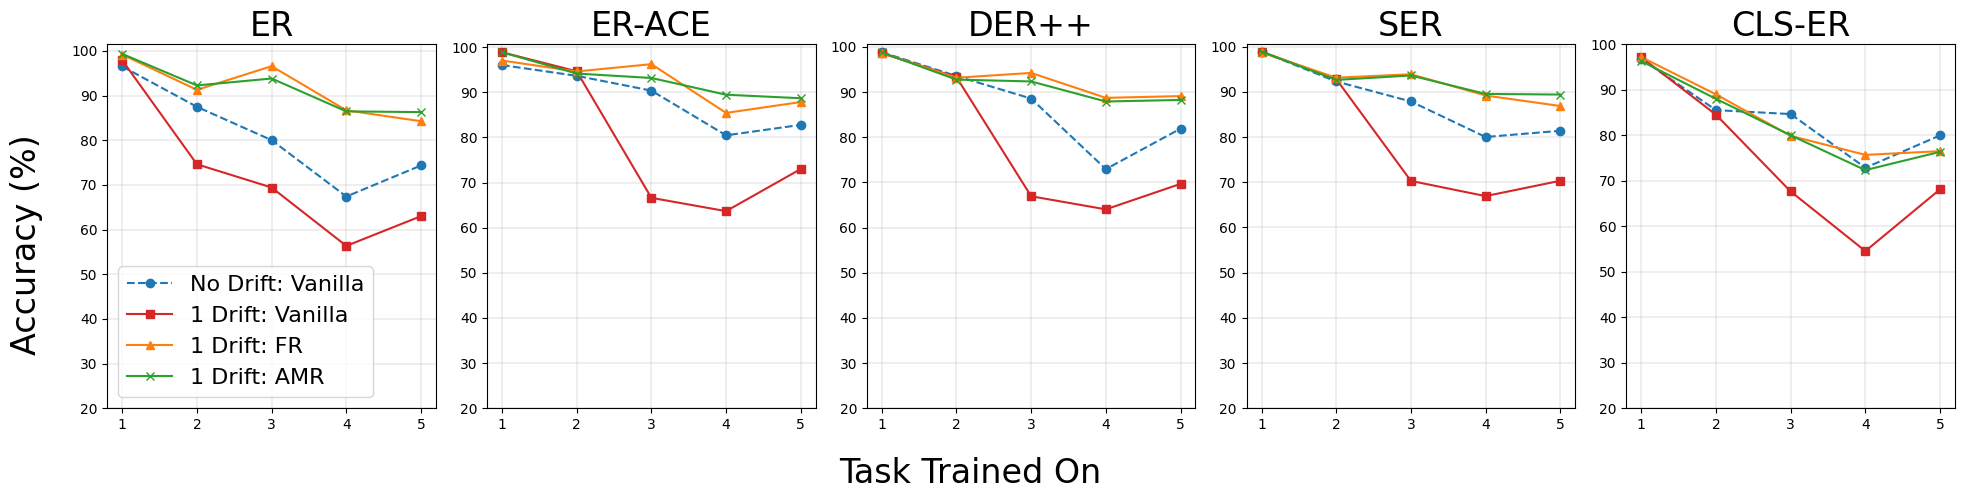

In [119]:
plot_cumulative_subplots(
    [
        er_500_accuracy_array_without_drift,
        er_500_accuracy_array_with_drift,
        er_500_accuracy_array_with_drift_full_relearning,
        er_500_accuracy_array_with_drift_buffer_resampling,
        er_ace_500_accuracy_array_without_drift,
        er_ace_500_accuracy_array_with_drift,
        er_ace_500_accuracy_array_with_drift_full_relearning,
        er_ace_500_accuracy_array_with_drift_buffer_resampling,
        derpp_500_accuracy_array_without_drift,
        derpp_500_accuracy_array_with_drift,
        derpp_500_accuracy_array_with_drift_full_relearning,
        derpp_500_accuracy_array_with_drift_buffer_resampling,
        ser_500_accuracy_array_without_drift,
        ser_500_accuracy_array_with_drift,
        ser_500_accuracy_array_with_drift_full_relearning,
        ser_500_accuracy_array_with_drift_buffer_resampling,
        clser_500_accuracy_array_without_drift,
        clser_500_accuracy_array_with_drift,
        clser_500_accuracy_array_with_drift_full_relearning,
        clser_500_accuracy_array_with_drift_buffer_resampling,
    ],
    ["ER", "ER-ACE", "DER++", "SER", "CLS-ER"],
    [
        "No Drift: Vanilla",
        "1 Drift: Vanilla",
        "1 Drift: FR",
        "1 Drift: AMR",
    ],
    plot_filename="FashionMNIST_Buff_500_n_1.pdf",
)

## Buffer 5000

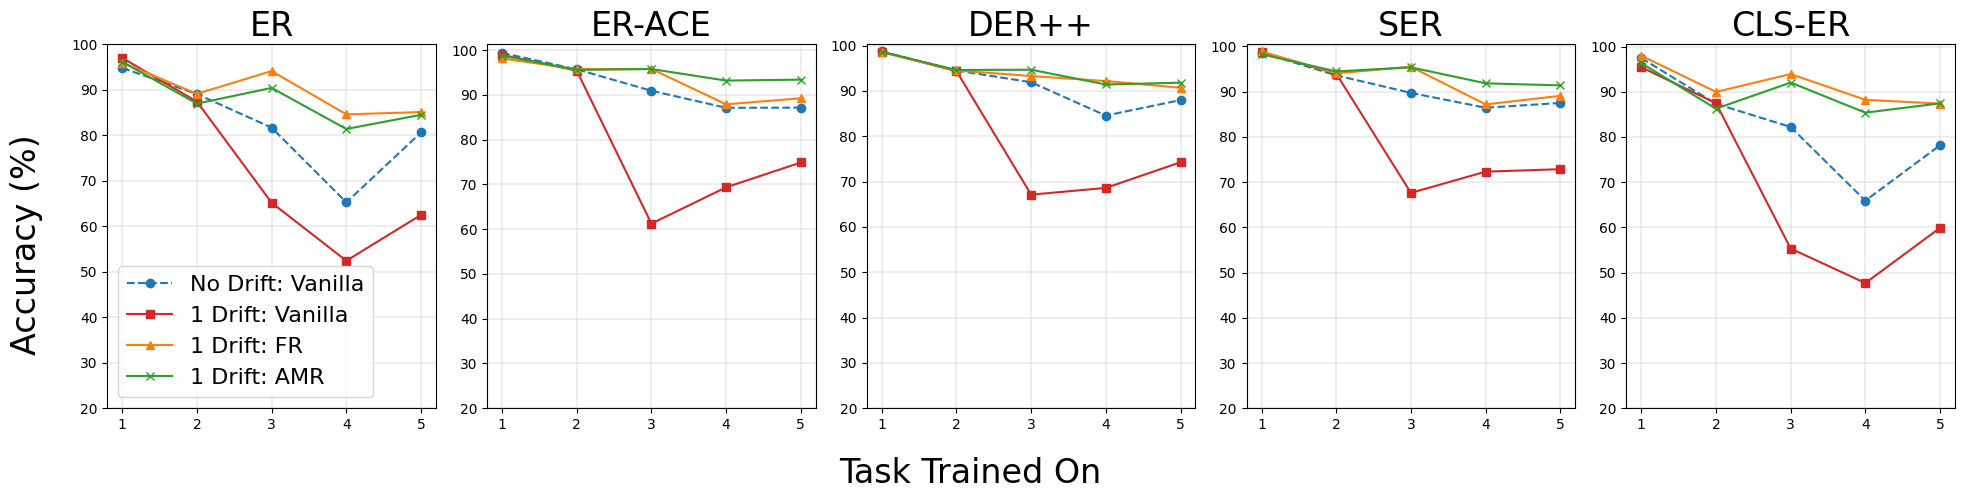

In [120]:
plot_cumulative_subplots(
    [
        er_5000_accuracy_array_without_drift,
        er_5000_accuracy_array_with_drift,
        er_5000_accuracy_array_with_drift_full_relearning,
        er_5000_accuracy_array_with_drift_buffer_resampling,
        er_ace_5000_accuracy_array_without_drift,
        er_ace_5000_accuracy_array_with_drift,
        er_ace_5000_accuracy_array_with_drift_full_relearning,
        er_ace_5000_accuracy_array_with_drift_buffer_resampling,
        derpp_5000_accuracy_array_without_drift,
        derpp_5000_accuracy_array_with_drift,
        derpp_5000_accuracy_array_with_drift_full_relearning,
        derpp_5000_accuracy_array_with_drift_buffer_resampling,
        ser_5000_accuracy_array_without_drift,
        ser_5000_accuracy_array_with_drift,
        ser_5000_accuracy_array_with_drift_full_relearning,
        ser_5000_accuracy_array_with_drift_buffer_resampling,
        clser_5000_accuracy_array_without_drift,
        clser_5000_accuracy_array_with_drift,
        clser_5000_accuracy_array_with_drift_full_relearning,
        clser_5000_accuracy_array_with_drift_buffer_resampling,
    ],
    ["ER", "ER-ACE", "DER++", "SER", "CLS-ER"],
    [
        "No Drift: Vanilla",
        "1 Drift: Vanilla",
        "1 Drift: FR",
        "1 Drift: AMR",
    ],
    plot_filename="FashionMNIST_Buff_5000_n_1.pdf",
)